!pip install gdown
!gdown --id 1_9NPC8E-kt4pU6rTi5lkh91eFR_jnFav --output sino_nom.zip
!unzip -u '/kaggle/working/sino_nom.zip'

In [ ]:
!pip install numpy-stl

In [1]:
g_path = 'wb_2D3Dretrieval_dataset/'

In [2]:
import numpy as np
from stl import mesh
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import io
import cv2

img_size = (256,256)
def crop(image):
    contours, hierarchy = cv2.findContours(image ,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    cropped_image = None

    min_x = min_y = float('inf')
    max_x = max_y = 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x==0 or y==0:
            continue
        # Tìm tọa độ min-max
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)
    return cv2.resize(image[min_y:max_y, min_x:max_x], img_size)  

def stl_to_2d(file_path):
    # Load the STL file
    _mesh = mesh.Mesh.from_file(file_path)
    # Compute the bounding box
    min_coords = np.min(_mesh.points, axis=0)
    max_coords = np.max(_mesh.points, axis=0)
    # Choose a cutting axis (e.g., the z-axis)
    cutting_axis = 2  # Assuming z-axis, change if needed
    # Find the coordinate value halfway between the minimum and maximum along the cutting axis
    cutting_plane = min_coords[cutting_axis] + 6*(max_coords[cutting_axis] - min_coords[cutting_axis]) / 7.0
    # Partition the model based on the cutting plane
    vectors_above_plane = []
    for vector in _mesh.vectors:
        # Check if all vertices of the triangle are above the cutting plane
        if np.all(vector[:, cutting_axis] > cutting_plane):
            vectors_above_plane.append(vector)
    # Create a new mesh object from the vectors above the cutting plane
    above_cutting_plane_mesh = mesh.Mesh(np.zeros(len(vectors_above_plane), dtype=mesh.Mesh.dtype))
    above_cutting_plane_mesh.vectors = vectors_above_plane

    figure = plt.figure()
    axes = figure.add_subplot(projection='3d')
    axes.view_init(elev=90, azim=-90)
    # Load the STL files and add the vectors to the plot
    poly_collection = mplot3d.art3d.Poly3DCollection(above_cutting_plane_mesh.vectors)
    poly_collection.set_color((0,0,0))  # play with color
    scale = above_cutting_plane_mesh.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    axes.add_collection3d(poly_collection)
    plt.grid(False)
    plt.axis('off')
    # Show the plot to the screen
    buffer = io.BytesIO()
    figure.savefig(buffer, format='jpg')
    buffer.seek(0)
    image_buffer = cv2.imdecode(np.frombuffer(buffer.getvalue(), dtype=np.uint8), -1)
    gray = cv2.cvtColor(image_buffer, cv2.COLOR_BGR2GRAY)
    ret,thresh_3d = cv2.threshold(gray,150,255,0)
    image_ = crop(thresh_3d)
    buffer.close()
    plt.close()
    return image_
    

In [ ]:

stl_path = os.path.join(g_path,'database') 
stl_2d_path = os.path.join(g_path,'stl_to_2d')
if not os.path.exists(stl_2d_path):
    os.mkdir(stl_2d_path) 
index=1
num_file= len(os.listdir(stl_path))
for file in os.listdir(stl_path): 
    print(f'{index}/{num_file}')
    index+=1
    path = os.path.join(stl_path,file)
    img_2d = stl_to_2d(path)
    out_path = os.path.join(stl_2d_path,file+'.png') 
    cv2.imwrite(out_path, img_2d)


In [3]:
# Process 2d images
def process_2d(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh_2d = cv2.threshold(gray,150,255,0)
    return crop(thresh_2d)

In [4]:
import types
import numpy as np
import cv2
from matplotlib import pyplot as plt

NoneType=type(None)

# ORB
def feature_matching_orb(img1, img2):
    orb = cv2.ORB_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance) 
    
    return np.float64(len(matches))

def compute_orb(img1):
    orb = cv2.ORB_create()

    kp1, des1 = orb.detectAndCompute(img1,None)

    return kp1, des1

def orb_matcher(des1, des2):
    if type(des1)!=NoneType and type(des2)!=NoneType:
        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        # Match descriptors.
        matches = bf.match(des1,des2)

        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance) 
        
        return np.float64(len(matches))
    else: 
        print(des1, des2)
        return 0

In [5]:
stl_2d_image_orb = []
binary_images_stl_2d_folder = os.path.join(g_path,'stl_to_2d')
for filename in os.listdir(binary_images_stl_2d_folder):
        image_path = os.path.join(binary_images_stl_2d_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        kp_image, des_image = compute_orb(image)
        stl_2d_image_orb.append((filename, kp_image, des_image))

In [6]:

def find_similar_ORB(img_path, stl_2d_image_orb):
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []
    
    kp_input_image, des_input_image = compute_orb(input_image)
    
    for filename, kp_database, des_database in stl_2d_image_orb:

        match = orb_matcher(des_database, des_input_image)
        image_matches.append((filename, match.max()))

    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[:5]]
    return top_5

In [7]:
stl_path = os.path.join(g_path,'database') 
stl_2d_path = os.path.join(g_path,'stl_to_2d')
num_file= len(os.listdir(stl_path))

In [8]:
f = open("wb_2D3Dretrieval_dataset/test_orb.csv", "w")
f.write('query,label\n')
print(g_path)
queries_path =  os.path.join(g_path,'queries') 
index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_file}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar_ORB(img_path, stl_2d_image_orb)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n' )
f.close()

wb_2D3Dretrieval_dataset/
1/252
2/252
3/252
4/252
5/252
6/252
7/252
8/252
9/252
10/252
11/252
12/252
13/252
14/252
15/252
16/252
17/252
18/252
19/252
20/252
21/252
22/252
23/252
24/252
25/252
26/252
27/252
28/252
29/252
30/252
31/252
32/252
33/252
34/252
35/252
36/252
37/252
38/252
39/252
40/252
41/252
42/252
43/252
44/252
45/252
46/252
47/252
48/252
49/252
50/252
51/252
52/252
53/252
54/252
55/252
56/252
57/252
58/252
59/252
60/252
61/252
62/252
63/252
64/252
65/252
66/252
67/252
68/252
69/252
70/252
71/252
72/252
73/252
74/252
75/252
76/252
77/252
78/252
79/252
80/252
81/252
82/252
83/252
84/252
85/252
86/252
87/252
88/252
89/252
90/252
91/252
92/252
93/252
94/252
95/252
96/252
97/252
98/252
99/252
100/252
101/252
102/252
103/252
104/252
105/252
106/252
107/252
108/252
109/252
110/252
111/252
112/252
113/252
114/252
115/252
116/252
117/252
118/252
119/252
120/252
121/252
122/252
123/252
124/252
125/252
126/252
127/252
128/252
129/252
130/252
131/252
132/252
133/252
134/252
135/252
13

In [13]:
# Visualiza the results
img_file_name = '83.png'
img1_path = os.path.join(queries_path, img_file_name)
# In ra đường dẫn của 5 ảnh tương tự nhất
top_5 = find_similar_ORB(img1_path, stl_2d_image_orb)
for image_path in top_5:
    print(image_path)

83.stl.png
210.stl.png
112.stl.png
207.stl.png
222.stl.png


In [14]:
# Read the sample csv
import csv
labels = {}
with open('wb_2D3Dretrieval_dataset/labels.csv', mode ='r')as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
        labels[lines[0]] = lines[1].split(',')

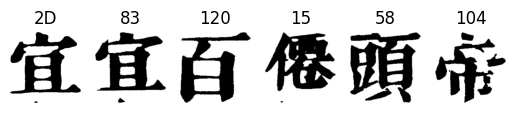

In [15]:
# Result from sample csv
csv_imgs = labels[img_file_name]
img2d = [cv2.imread(os.path.join(stl_2d_path,p+ '.png')) for p in csv_imgs]
plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
plt.axis('off')
plt.subplot(162),plt.imshow(img2d[0]),plt.title(csv_imgs[0][:-4])
plt.axis('off')
plt.subplot(163),plt.imshow(img2d[1]),plt.title(csv_imgs[1][:-4])
plt.axis('off')
plt.subplot(164),plt.imshow(img2d[2]),plt.title(csv_imgs[2][:-4])
plt.axis('off')
plt.subplot(165), plt.imshow(img2d[3]),plt.title(csv_imgs[3][:-4])
plt.axis('off')
plt.subplot(166),plt.imshow(img2d[4]),plt.title(csv_imgs[4][:-4])
plt.axis('off')
plt.show()

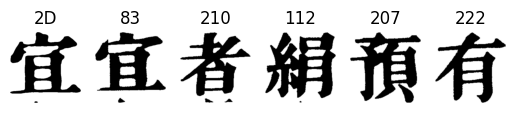

In [16]:
# Final results
img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
plt.axis('off')
plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
plt.axis('off')
plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
plt.axis('off')
plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
plt.axis('off')
plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
plt.axis('off')
plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
plt.axis('off')
plt.show()